# Q Learning & Deep Q Network Examples
Deep Q Network is implemented using Tensorflow

In [22]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from time import time

In [23]:
seed = 1546847731  # or try a new seed by using: seed = int(time())
random.seed(seed)
print(f'Seed: {seed}')

Seed: 1546847731


### Game design
The game the Q-agents will need to learn is made of a board with 4 cells. The agent will receive a +1 reward every time it fills a vacant cell, and will receive a -1 penalty when it tries to fill an already filled cell. Game ends when the board is full.

In [24]:
class Game:
    board = None
    board_size = 0
    
    def __init__(self, board_size=4):
        self.board_size = board_size
        self.reset()
    
    def reset(self):
        self.board = np.zeros(self.board_size)
    
    def play(self, cell):
        # returns a tuple: (reward, game_over?)
        if self.board[cell] == 0:
            self.board[cell] = 1
            game_over = len(np.where(self.board == 0)[0]) == 0
            return (1,game_over)
        else:
            return (-1,False)

In [25]:
def state_to_str(state):
    return str(list(map(int,state.tolist())))

all_states = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                s = np.array([i,j,k,l])
                all_states.append(state_to_str(s))
                
print('All possible states:')
for s in all_states:
    print(s)

All possible states:
[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 0, 1, 0]
[0, 0, 1, 1]
[0, 1, 0, 0]
[0, 1, 0, 1]
[0, 1, 1, 0]
[0, 1, 1, 1]
[1, 0, 0, 0]
[1, 0, 0, 1]
[1, 0, 1, 0]
[1, 0, 1, 1]
[1, 1, 0, 0]
[1, 1, 0, 1]
[1, 1, 1, 0]
[1, 1, 1, 1]


Initialize the game:

In [26]:
game = Game()

## Q Learning
Starting of with a table-based Q-learning algorithm.

In [7]:
num_of_games = 2000
epsilon = 0.1
gamma = 1

Initializing the Q-table:

In [8]:
q_table = pd.DataFrame(0, index=np.arange(4), columns=all_states)

Letting the agent play and learn:

In [9]:
r_list = []  # store the total reward of each game so we can plot it later

for g in range(num_of_games):
    game_over = False
    game.reset()
    total_reward = 0
    while not game_over:
        state = np.copy(game.board)
        if random.random() < epsilon:
            action = random.randint(0,3)
        else:
            action = q_table[state_to_str(state)].idxmax()
        reward, game_over = game.play(action)
        total_reward += reward
        if np.sum(game.board) == 4:  # terminal state
            next_state_max_q_value = 0
        else:
            next_state = np.copy(game.board)
            next_state_max_q_value = q_table[state_to_str(next_state)].max()
        q_table.loc[action,state_to_str(state)] = reward + gamma * next_state_max_q_value
    r_list.append(total_reward)
q_table

,"[0, 0, 0, 0]","[0, 0, 0, 1]","[0, 0, 1, 0]","[0, 0, 1, 1]","[0, 1, 0, 0]","[0, 1, 0, 1]","[0, 1, 1, 0]","[0, 1, 1, 1]","[1, 0, 0, 0]","[1, 0, 0, 1]","[1, 0, 1, 0]","[1, 0, 1, 1]","[1, 1, 0, 0]","[1, 1, 0, 1]","[1, 1, 1, 0]","[1, 1, 1, 1]"
0,4,3,3,2,3,2,2,0,2,1,1,-1,1,0,0,0
1,4,1,0,0,0,0,0,0,3,2,2,1,1,0,0,0
2,4,3,2,0,3,0,-1,0,3,2,1,0,2,1,0,0
3,4,2,3,0,0,0,0,0,3,0,2,0,2,0,1,0


Let's verify that the agent indeed learned a correct startegy by seeing what action it will choose in each one of the possible states:

In [10]:
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                b = np.array([i,j,k,l])
                if len(np.where(b == 0)[0]) != 0:
                    action = q_table[state_to_str(b)].idxmax()
                    pred = q_table[state_to_str(b)].tolist()
                    print('board: {b}\tpredicted Q values: {p} \tbest action: {a}\tcorrect action? {s}'
                          .format(b=b,p=pred,a=action,s=b[action]==0))

board: [0 0 0 0]	predicted Q values: [4, 4, 4, 4] 	best action: 0	correct action? True
board: [0 0 0 1]	predicted Q values: [3, 1, 3, 2] 	best action: 0	correct action? True
board: [0 0 1 0]	predicted Q values: [3, 0, 2, 3] 	best action: 0	correct action? True
board: [0 0 1 1]	predicted Q values: [2, 0, 0, 0] 	best action: 0	correct action? True
board: [0 1 0 0]	predicted Q values: [3, 0, 3, 0] 	best action: 0	correct action? True
board: [0 1 0 1]	predicted Q values: [2, 0, 0, 0] 	best action: 0	correct action? True
board: [0 1 1 0]	predicted Q values: [2, 0, -1, 0] 	best action: 0	correct action? True
board: [0 1 1 1]	predicted Q values: [0, 0, 0, 0] 	best action: 0	correct action? True
board: [1 0 0 0]	predicted Q values: [2, 3, 3, 3] 	best action: 1	correct action? True
board: [1 0 0 1]	predicted Q values: [1, 2, 2, 0] 	best action: 1	correct action? True
board: [1 0 1 0]	predicted Q values: [1, 2, 1, 2] 	best action: 1	correct action? True
board: [1 0 1 1]	predicted Q values: [-1, 

We can see the agent indeed picked up the right way to play the game. Still, when looking at the predicted Q values, we see that there are some states where he didn't pick up the correct Q values. For example, look at the Q table above for the state `[0,0,1,0]`. The Q value the agent learned for the action "1" is lower than that of the action "2", and this is obviously wrong, as cell 1 is vacant and cell 2 is not (remember the first cell is cell 0). This is due to the fact that the agent didn't reach this state and selected those actions enough times. This is because the Q learning is a greedy algorithm. and prefers to choose the best action he can rather than explore. We can solve this issue increasing $\epsilon$ (`epsilon`), which controls the exploration of this algorithm and was set to 0.1, or by letting the agent play more games.

Let's plot the total reward the agent received per game:

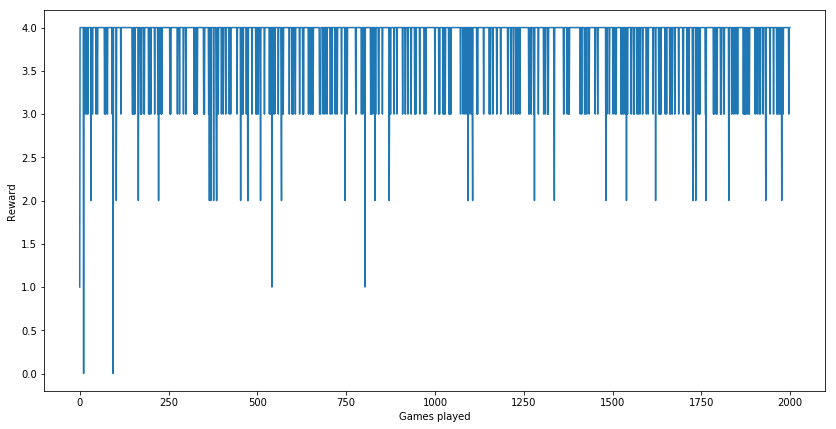

In [11]:
plt.figure(figsize=(14,7))
plt.plot(range(len(r_list)),r_list)
plt.xlabel('Games played')
plt.ylabel('Reward')
plt.show()

## Deep Q Network
Moving on to neural-network-based modeling. Let's start by designing the Q network. Remember the output ot the network (`self.output`) is an array of the predicted Q value for each action taken from the input state (`self.states`). Comparing to the Q-table algorithm, the output is an entire column of the table.  

In [12]:
class QNetwork:
    def __init__(self, hidden_layers_size, gamma, learning_rate, input_size=4, output_size=4):
        self.q_target = tf.placeholder(shape=(None,output_size), dtype=tf.float32)
        self.r = tf.placeholder(shape=None,dtype=tf.float32)
        self.states = tf.placeholder(shape=(None, input_size), dtype=tf.float32)
        self.enum_actions = tf.placeholder(shape=(None,2), dtype=tf.int32) 
        layer = self.states
        for l in hidden_layers_size:
            layer = tf.layers.dense(inputs=layer, units=l, activation=tf.nn.relu,
                                    kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))
        self.output = tf.layers.dense(inputs=layer, units=output_size,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))
        self.predictions = tf.gather_nd(self.output,indices=self.enum_actions)
        self.labels = self.r + gamma * tf.reduce_max(self.q_target, axis=1)
        self.cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=self.labels, predictions=self.predictions))
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.cost)

Designing the Experience Replay memory which will be used, usign a cyclic memory buffer:

In [13]:
class ReplayMemory:
    memory = None
    counter = 0

    def __init__(self, size):
        self.memory = deque(maxlen=size)

    def append(self, element):
        self.memory.append(element)
        self.counter += 1

    def sample(self, n):
        return random.sample(self.memory, n)

Settint up parameters. Notice that here I used `gamma = 0.99` and not 1 like in the Q-table algorithm, as the literature recommneds working with a discount factor of $0.9 \le \gamma \le 0.99$. It probably won't matter much in this specific case, but it's good to get used to this.

In [14]:
num_of_games = 2000
epsilon = 0.1
gamma = 0.99
batch_size = 10
memory_size = 2000

Initializing the Q-network:

In [15]:
tf.reset_default_graph()
tf.set_random_seed(seed)
qnn = QNetwork(hidden_layers_size=[20,20], gamma=gamma, learning_rate=0.001)
memory = ReplayMemory(memory_size)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Training the network. Compare this code to the above Q-table training.

In [16]:
r_list = []  
c_list = []  # same as r_list, but for the cost

counter = 0  # will be used to trigger network training

for g in range(num_of_games):
    game_over = False
    game.reset()
    total_reward = 0
    while not game_over:
        counter += 1
        state = np.copy(game.board)
        if random.random() < epsilon:
            action = random.randint(0,3)
        else:
            pred = np.squeeze(sess.run(qnn.output,feed_dict={qnn.states: np.expand_dims(game.board,axis=0)}))
            action = np.argmax(pred)
        reward, game_over = game.play(action)
        total_reward += reward
        next_state = np.copy(game.board)
        memory.append({'state':state,'action':action,'reward':reward,'next_state':next_state,'game_over':game_over})
        if counter % batch_size == 0:
            # Network training
            batch = memory.sample(batch_size)
            q_target = sess.run(qnn.output,feed_dict={qnn.states: np.array(list(map(lambda x: x['next_state'], batch)))})
            terminals = np.array(list(map(lambda x: x['game_over'], batch)))
            for i in range(terminals.size):
                if terminals[i]:
                    # Remember we use the network's own predictions for the next state while calculatng loss.
                    # Terminal states have no Q-value, and so we manually set them to 0, as the network's predictions
                    # for these states is meaningless
                    q_target[i] = np.zeros(game.board_size)
            _, cost = sess.run([qnn.optimizer, qnn.cost], 
                               feed_dict={qnn.states: np.array(list(map(lambda x: x['state'], batch))),
                               qnn.r: np.array(list(map(lambda x: x['reward'], batch))),
                               qnn.enum_actions: np.array(list(enumerate(map(lambda x: x['action'], batch)))),
                               qnn.q_target: q_target})
            c_list.append(cost)
    r_list.append(total_reward)
print('Final cost: {}'.format(c_list[-1]))

Final cost: 1.0163466930389404


Again, let's verify that the agent indeed learned a correct startegy:

In [17]:
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                b = np.array([i,j,k,l])
                if len(np.where(b == 0)[0]) != 0:
                    pred = np.squeeze(sess.run(qnn.output,feed_dict={qnn.states: np.expand_dims(b,axis=0)}))
                    pred = list(map(lambda x: round(x,3),pred))
                    action = np.argmax(pred)
                    print('board: {b}\tpredicted Q values: {p} \tbest action: {a}\tcorrect action? {s}'
                          .format(b=b,p=pred,a=action,s=b[action]==0))

board: [0 0 0 0]	predicted Q values: [0.316, 0.036, 0.172, -0.353] 	best action: 0	correct action? True
board: [0 0 0 1]	predicted Q values: [-0.343, -0.881, -0.185, -1.364] 	best action: 2	correct action? True
board: [0 0 1 0]	predicted Q values: [0.311, 0.753, -0.332, -0.009] 	best action: 1	correct action? True
board: [0 0 1 1]	predicted Q values: [0.118, 0.273, -0.558, -0.772] 	best action: 1	correct action? True
board: [0 1 0 0]	predicted Q values: [0.458, -0.038, 0.225, -0.068] 	best action: 0	correct action? True
board: [0 1 0 1]	predicted Q values: [0.255, -0.866, 0.019, -1.028] 	best action: 0	correct action? True
board: [0 1 1 0]	predicted Q values: [0.468, 0.476, 0.15, 0.51] 	best action: 3	correct action? True
board: [0 1 1 1]	predicted Q values: [0.892, 0.211, -0.061, -0.08] 	best action: 0	correct action? True
board: [1 0 0 0]	predicted Q values: [-0.081, 0.168, 0.48, -0.011] 	best action: 2	correct action? True
board: [1 0 0 1]	predicted Q values: [-0.899, -0.586, 0.144,

Here too, we see the agent learned a correct strategy, and again, Q values are not what we would've expected.

Let's plot the rewards the agent received:

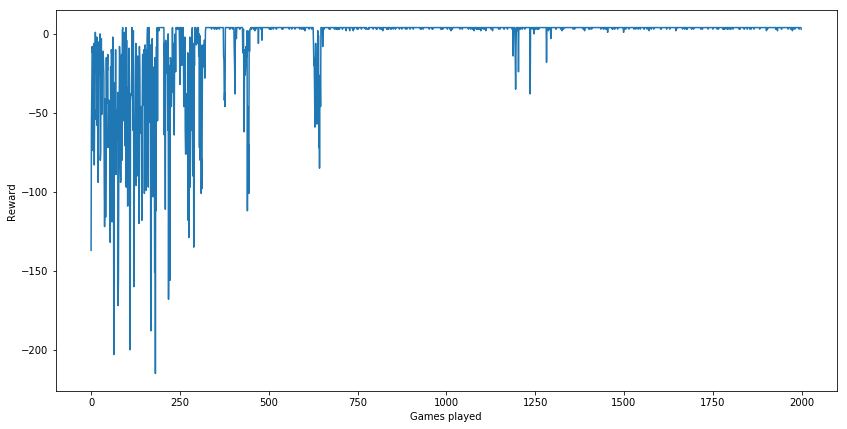

In [18]:
plt.figure(figsize=(14,7))
plt.plot(range(len(r_list)),r_list)
plt.xlabel('Games played')
plt.ylabel('Reward')
plt.show()

Zooming in, so we can compare the the Q-table algorithm:

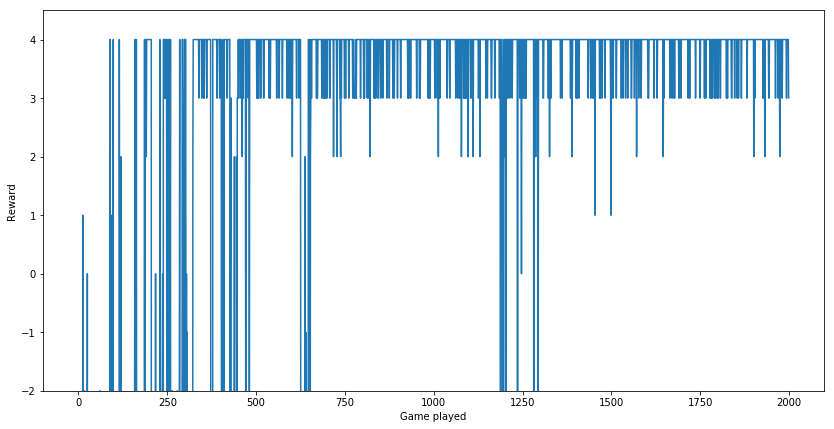

In [19]:
plt.figure(figsize=(14,7))
plt.plot(range(len(r_list)),r_list)
plt.xlabel('Game played')
plt.ylabel('Reward')
plt.ylim(-2,4.5)
plt.show()

Let's plot the cost too. Remeber that here the _x_-axis reflects the number of trainigns, and not the number of games. The number of training depends on the number of actions taken, and the agent can take any number of actions during each game.

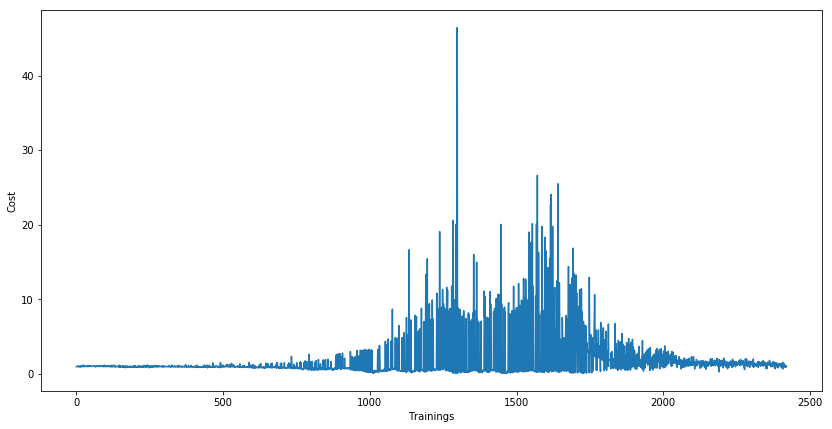

In [20]:
plt.figure(figsize=(14,7))
plt.plot(range(len(c_list)),c_list)
plt.xlabel('Trainings')
plt.ylabel('Cost')
plt.show()

In [21]:
sess.close()  # Don't forget to close tf.session